<a href="https://colab.research.google.com/github/dpostolovski/eeg_is/blob/visualization_d/IS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


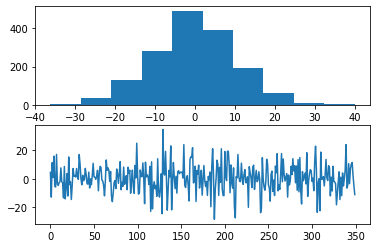

In [0]:
#@title Default title text
from scipy import io
import matplotlib.pyplot as plt
v = io.loadmat('drive/My Drive/Data/trainData.mat')
t = v['trainData']
t[0].shape

fig, axs = plt.subplots(2)
# plot histogram
axs[0].hist(t[0][3])
axs[1].plot(range(0,350), t[0][2][0:350])

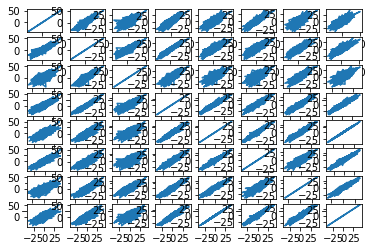

In [0]:
#@title Default title text
from scipy import io
import matplotlib.pyplot as plt
v = io.loadmat('drive/My Drive/Data/trainData.mat')
t = v['trainData']
t[0].shape

k = 0
fig, axs = plt.subplots(8,8)
for i in range(8):
  for y in range(8):
    axs[i,y].plot(t[i][0], t[y][0])
# plot histogram


In [0]:
!pip install -U -q scipy